In [ ]:
pip install tensorflow
pip install scipy

In [1]:
# IMAGE CLASSIFIER FOR FLOORPLANS

In [1]:
import os

In [2]:
base_dir = './floorplans/Final_dataset/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training floorplans pictures
train_floorplans_dir = os.path.join(train_dir, 'floorplans')

# Directory with our training notfloorplans pictures
train_notfloorplans_dir = os.path.join(train_dir, 'notfloorplans')

# Directory with our validation floorplans pictures
validation_floorplans_dir = os.path.join(validation_dir, 'floorplans')

# Directory with our validation notfloorplans pictures
validation_notfloorplans_dir = os.path.join(validation_dir, 'notfloorplans')

In [3]:
train_floorplan_fnames = os.listdir(train_floorplans_dir)
print(train_floorplan_fnames[:10])

train_notfloorplan_fnames = os.listdir(train_notfloorplans_dir)
train_notfloorplan_fnames.sort()
print(train_notfloorplan_fnames[:10])

['floorplan.213.jpg', 'floorplan.207.jpg', 'floorplan.69.jpg', 'floorplan.41.jpg', 'floorplan.55.jpg', 'floorplan.82.jpg', 'floorplan.96.jpg', 'floorplan.165.jpg', 'floorplan.171.jpg', 'floorplan.159.jpg']
['notfloorplan0.jpg', 'notfloorplan1.jpg', 'notfloorplan10.jpg', 'notfloorplan100.jpg', 'notfloorplan101.jpg', 'notfloorplan102.jpg', 'notfloorplan103.jpg', 'notfloorplan104.jpg', 'notfloorplan105.jpg', 'notfloorplan106.jpg']


In [4]:
print('total training floorplans images:', len(os.listdir(train_floorplans_dir)))
print('total training notfloorplans images:', len(os.listdir(train_notfloorplans_dir)))
print('total validation floorplans images:', len(os.listdir(validation_floorplans_dir)))
print('total validation notfloorplans images:', len(os.listdir(validation_notfloorplans_dir)))

total training floorplans images: 500
total training notfloorplans images: 500
total validation floorplans images: 250
total validation notfloorplans images: 250


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

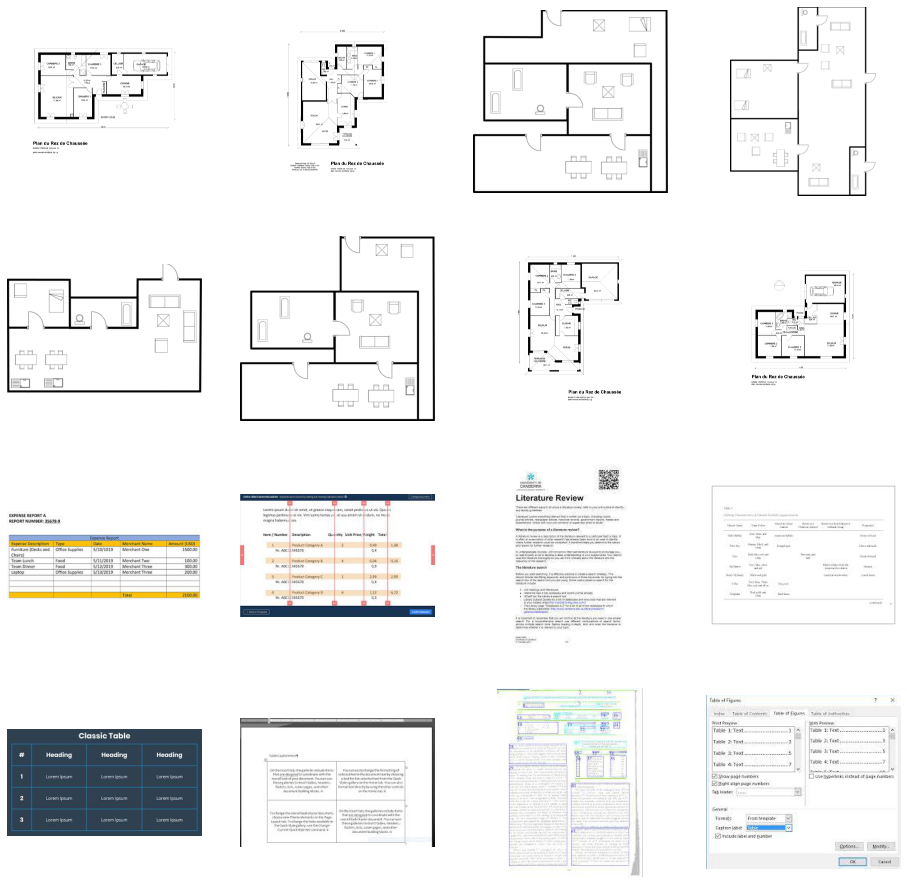

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_floorplan_pix = [os.path.join(train_floorplans_dir, fname) 
                for fname in train_floorplan_fnames[pic_index-8:pic_index]]
next_notfloorplan_pix = [os.path.join(train_notfloorplans_dir, fname) 
                for fname in train_notfloorplan_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_floorplan_pix+next_notfloorplan_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [8]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [9]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,  # 500 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=25,  # 250 images = batch_size * steps
      verbose=2)

Epoch 1/15
50/50 - 33s - loss: 0.2158 - acc: 0.9400 - val_loss: 0.4861 - val_acc: 0.8080
Epoch 2/15
50/50 - 28s - loss: 0.1381 - acc: 0.9600 - val_loss: 0.1419 - val_acc: 0.9640
Epoch 3/15
50/50 - 28s - loss: 0.1754 - acc: 0.9520 - val_loss: 0.1911 - val_acc: 0.9360
Epoch 4/15
50/50 - 29s - loss: 0.1151 - acc: 0.9740 - val_loss: 0.1637 - val_acc: 0.9400
Epoch 5/15
50/50 - 27s - loss: 0.0934 - acc: 0.9740 - val_loss: 0.1941 - val_acc: 0.9400
Epoch 6/15
50/50 - 27s - loss: 0.0571 - acc: 0.9820 - val_loss: 0.1176 - val_acc: 0.9760
Epoch 7/15
50/50 - 28s - loss: 0.0681 - acc: 0.9860 - val_loss: 0.0933 - val_acc: 0.9720
Epoch 8/15
50/50 - 29s - loss: 0.0566 - acc: 0.9860 - val_loss: 0.1449 - val_acc: 0.9760
Epoch 9/15
50/50 - 29s - loss: 0.0233 - acc: 0.9940 - val_loss: 0.0677 - val_acc: 0.9840
Epoch 10/15
50/50 - 27s - loss: 0.0191 - acc: 0.9940 - val_loss: 0.1858 - val_acc: 0.9640
Epoch 11/15
50/50 - 31s - loss: 0.0486 - acc: 0.9920 - val_loss: 0.2016 - val_acc: 0.9800
Epoch 12/15
50/50 -

/Users/areebakamil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


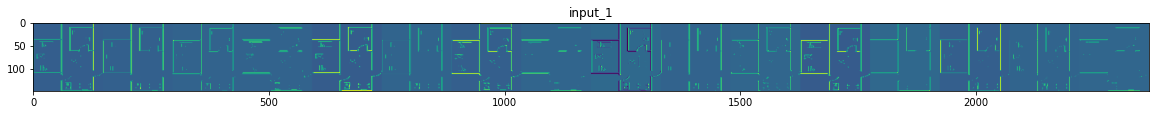

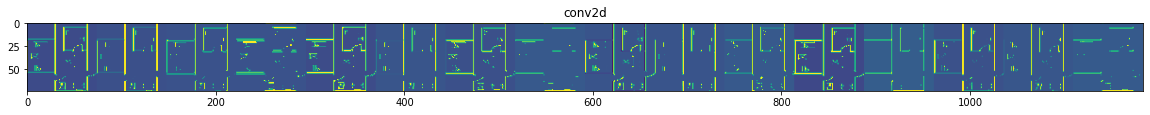

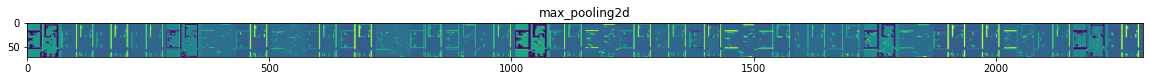

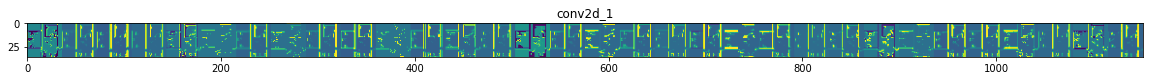

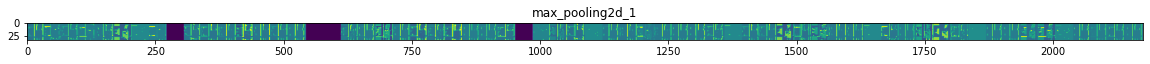

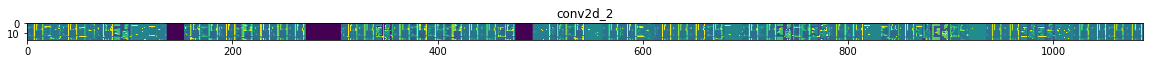

In [16]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
floorplan_img_files = [os.path.join(train_floorplans_dir, f) for f in train_floorplan_fnames]
notfloorplan_img_files = [os.path.join(train_notfloorplans_dir, f) for f in train_notfloorplan_fnames]
img_path = random.choice(floorplan_img_files + notfloorplan_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

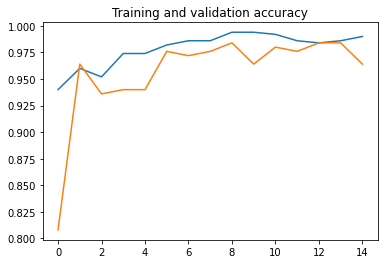

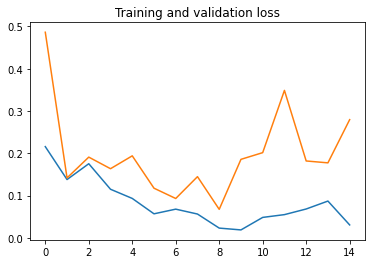

In [17]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# training accuracy is blue

In [19]:
model.save('image_classification_v1')

INFO:tensorflow:Assets written to: image_classification_v1/assets
